# Análisis de la base de datos de una aplicación de libros
**Objetivo:** estudiar la base de datos mediante querys en SQL para generar una propuesta de valor para un nuevo producto.

**Tareas**
- Número de libros publicados después del 1 de enero de 2000.
- Número de reseñas de usuarios y la calificación promedio para cada libro.
- Identifica la editorial que ha publicado el mayor número de libros con más de 50 páginas (esto te ayudará a excluir folletos y publicaciones similares de tu análisis).
- Identifica al autor que tiene la más alta calificación promedio del libro: mira solo los libros con al menos 50 calificaciones.
- Encuentra el número promedio de reseñas de texto entre los usuarios que calificaron más de 50 libros.

## Diccionario de datos
**`books`**

Contiene datos sobre libros:

- `book_id`: identificación del libro
- `author_id`: identificación del autor o autora
- `title`: título
- `num_pages`: número de páginas
- `publication_date`: fecha de la publicación
- `publisher_id`: identificación de la editorial

**`authors`**

Contiene datos sobre autores:

- `author_id`: identificación del autor o autora
- `author`: el autor o la autora

**`publishers`**

Contiene datos sobre editoriales:

- `publisher_id`: identificación de la editorial
- `publisher`: la editorial

**`ratings`**

Contiene datos sobre las calificaciones de usuarios:

- `rating_id`: identificación de la calificación
- `book_id`: identificación del libro
- `username`: el nombre del usuario que revisó el libro
- `rating`: calificación

**`reviews`**

Contiene datos sobre las reseñas de los y las clientes:

- `review_id`: identificación de la reseña
- `book_id`: identificación del libro
- `username`: el nombre del usuario que revisó el libro
- `text`: el texto de la reseña

## Diagrama de datos
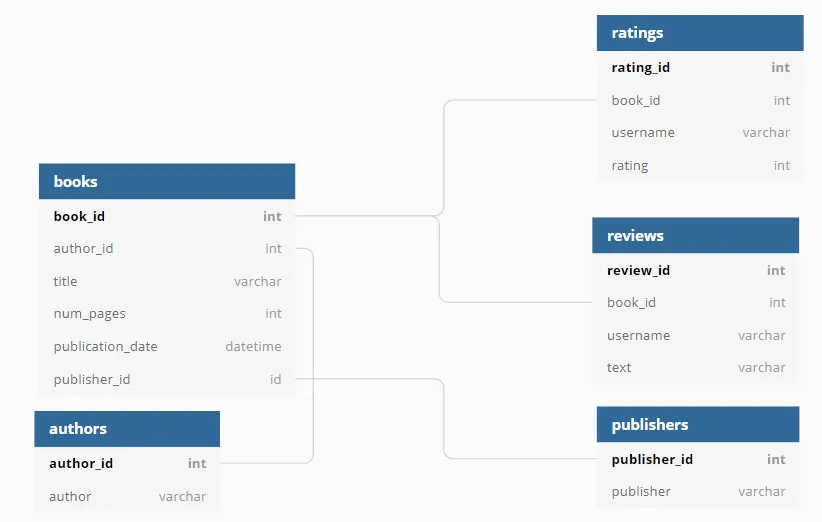